In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string

import torch
import torch.nn as nn
import joblib

In [2]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
mid = "100pct_3day-removed"
path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mid}_outputs"

In [4]:
model = MLP(10)
model.load_state_dict(torch.load(f'{path}/model_{mid}.pt'))
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [5]:
y_df = pd.read_csv(f'{path}/y_df_{mid}.csv')
y_test = y_df.pop('y_test')
y_pred = y_df.pop('y_pred')

with open(f'{path}/scaler_{mid}.pkl', 'rb') as f:
    scaler = joblib.load(f)

col_names = y_df.columns.to_list()
norm_arr = scaler.inverse_transform(y_df)
y_df = pd.DataFrame(norm_arr, columns=col_names)
y_df['y_test'] = y_test
y_df['y_pred'] = y_pred
y_df['y_diff'] = y_df['y_pred'] - y_df['y_test']
y_df

,mlt,lon,lat,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,mlt_sin,mlt_cos,lon_sin,lon_cos,y_test,y_pred,y_diff
0,23.394093,350.911392,73.448276,-5.14,1.02,593.0,4.12,-0.343352,-0.157962,0.987445,-0.175171,0.984538,-9.857609,-9.012956,0.844653
1,10.972996,164.594937,61.034483,-9.11,-7.64,450.0,11.68,0.199556,0.265641,-0.964072,0.282426,-0.959289,-0.721656,-4.986388,-4.264732
2,12.487764,187.316456,88.620690,10.19,-9.38,495.0,3.84,-0.448049,-0.127349,-0.991858,-0.110020,-0.993929,37.351574,38.812800,1.461226
3,1.581435,23.721519,78.965517,-0.38,-4.85,661.0,1.14,0.559946,0.402292,0.915512,0.386252,0.922393,-5.183209,-12.332151,-7.148942
4,12.184810,182.772152,80.344828,9.28,-0.09,467.0,11.45,-0.447279,-0.048364,-0.998830,-0.030925,-0.999522,11.366619,15.438332,4.071713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10778,19.758650,296.379747,66.551724,0.29,-1.14,552.0,3.99,0.145632,-0.895869,0.444319,-0.903487,0.428616,14.915684,9.129083,-5.786601
10779,6.428692,96.430380,78.965517,0.67,1.72,397.0,7.93,-0.291335,0.993709,-0.111996,0.995512,-0.094636,-5.139636,-8.992495,-3.852859
10780,12.790717,191.860759,88.620690,-3.58,0.30,670.0,1.22,-0.446460,-0.205534,-0.978650,-0.188423,-0.982088,-16.056797,-16.500158,-0.443361
10781,13.396624,200.949367,83.103448,-1.88,-1.01,317.0,12.64,0.493383,-0.357543,-0.933897,-0.341190,-0.939995,-2.517504,-3.115113,-0.597609


In [6]:
mae = np.mean(np.abs(y_df['y_diff']))
rmse = np.sqrt(np.mean(y_df['y_diff'] ** 2))
R = np.corrcoef(y_df['y_pred'], y_df['y_test'])[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill             

PE = skill(y_pred, y_test)

print(f"MAE: {mae:.2f} [kV]")
print(f"RMSE: {rmse:.2f} [kV]")
#print(f"Mean Abs Err pct: {err_pct:.1f}%")
print(f"Correlation: {R:.2f}")
print(f"Skill: {PE:.2f}")

MAE: 4.90 [kV]
RMSE: 7.66 [kV]
Correlation: 0.76
Skill: 0.56


In [7]:
y_df['lon'] = y_df['lon'].round()
y_df['lat'] = y_df['lat'].round()
y_df = y_df.set_index(['lat', 'lon']) 
y_df = y_df.groupby(['lat', 'lon']).mean()
y_ds = y_df.to_xarray()
y_ds

<xarray.Dataset> Size: 250kB
Dimensions:         (lat: 30, lon: 80)
Coordinates:
  * lat             (lat) float64 240B 50.0 51.0 53.0 54.0 ... 87.0 89.0 90.0
  * lon             (lon) float64 640B 1.0 6.0 10.0 15.0 ... 351.0 355.0 360.0
Data variables: (12/13)
    mlt             (lat, lon) float64 19kB 0.06667 0.3696 0.6726 ... 23.7 0.0
    BY_GSE          (lat, lon) float64 19kB 2.97 -1.564 -4.0 ... -0.3725 -1.787
    BZ_GSE          (lat, lon) float64 19kB -0.218 -0.546 0.43 ... -0.49 -0.4333
    flow_speed      (lat, lon) float64 19kB 453.8 464.4 437.0 ... 458.5 400.3
    proton_density  (lat, lon) float64 19kB 3.794 3.984 0.57 ... 4.975 4.14
    tilt_angle      (lat, lon) float64 19kB 0.2442 -0.02568 ... 0.07986 -0.2067
    ...              ...
    mlt_cos         (lat, lon) float64 19kB 0.9998 0.9953 0.9845 ... 0.9969 1.0
    lon_sin         (lat, lon) float64 19kB 0.0 0.07923 ... -0.09662 -0.01745
    lon_cos         (lat, lon) float64 19kB 1.0 0.9969 0.9874 ... 0.9953 0.9998
    y_test          (lat, lon) float64 19kB 2.053 1.371 0.3463 ... -4.394 -10.14
    y_pred          (lat, lon) float64 19kB 0.7213 -0.2603 ... -8.58 -8.341
    y_diff          (lat, lon) float64 19kB -1.332 -1.631 ... -4.186 1.796

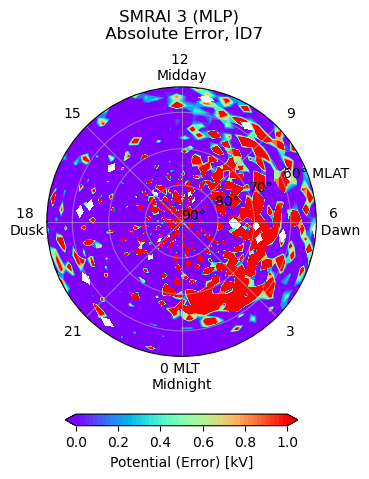

In [8]:
# Define the polar plot parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

abs_error = (y_ds['y_diff'].values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 1, 50), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 3 (MLP) \n Absolute Error, ID7', pad=10, fontsize=12)
plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.15, ticks=np.arange(0,1.1,0.2), orientation='horizontal')
ax.grid(True, linestyle='-', alpha=0.6)

#plt.savefig('MLP_potential_ID7.png', dpi=300, bbox_inches='tight')

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sachin/miniconda3/envs/torc

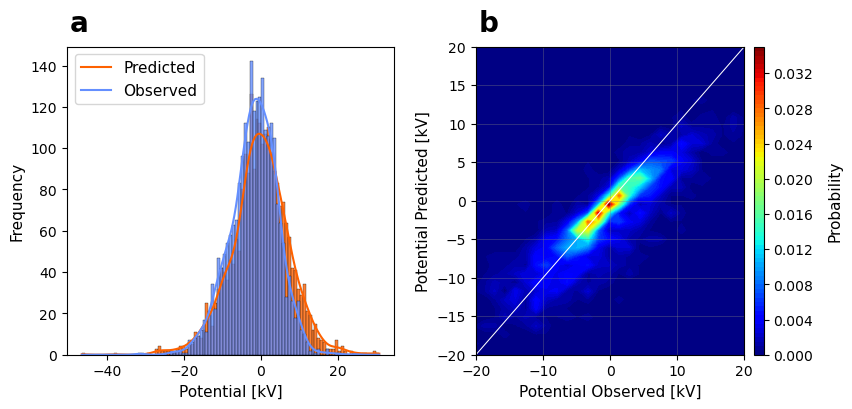

In [51]:
def create_diagonal_ref_plot(df):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9.5, 4))
    #plt.figure(figsize=(6, 5))

    y_test = df['y_test'].to_numpy()
    y_true = y_test
    y_pred = df['y_pred'].to_numpy()

    #number of samples
    length =  df.shape[0]

    #y_test = np.asarray(y_true).flatten()
    #y_pred = np.asarray(y_pred).flatten()

    #skewness = stats.skew(y_true)

    mae = np.mean(np.abs(y_test - y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    corr = np.corrcoef(y_test, y_pred)[0,1]
    corr = round(corr, 2)

    def extremes(x, pwr):
        t = np.sum((x - np.mean(x))**pwr)
        b = (len(y_pred)) * (np.std(x))**pwr
        return t / b

    #skew = extremes (m,3) - extremes(o, 3)
    kurt = round(extremes (y_pred,4) - extremes(y_test, 4),2)
    #negative kurtosis (also known as platykurtic) means that the distribution has 
    #thinner tails and a flatter peak compared to a normal distribution.

    #skill score
    def skill(m, o):
        skill = 1 - (np.sum((m - o)**2) / 
                np.sum((o - np.mean(o))**2))

        return skill             

    skill = skill(y_pred, y_test)
    # skill = 1 - (np.sum((y_test - y_pred)**2) / np.sum((np.abs(y_pred - np.mean(y_test)) + np.abs(y_test - np.mean(y_test)))**2))
    skill = round(skill, 2)

    H, xedges, yedges = np.histogram2d(y_true, y_pred, bins=50)     #edges refers to the bin edges
    H = H / np.sum(H) #H is the 2d hist, + normalise by the sum of all bins
    X, Y = np.meshgrid(xedges, yedges) #create rectangular grid from x and y edges

    cont = plt.contourf(X[:-1, :-1], Y[:-1, :-1], H.T, cmap='jet', levels=75)
    #change colorbar ticks
    #plt.scatter(y_true, y_pred, color='black', alpha=0.2)
    #sns.kdeplot(x=y_pred, y=y_true, cmap='jet')

    # Add diagonal line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())    
    plt.plot([min_val, max_val], [min_val, max_val], color='white', linestyle='-', linewidth=.75)

    font_size = 11

    #add info on plot
    n, R, PE = r'$n$', r'$R$', r'$PE$'
    #plt.text(15, -45, f'{n} = {length:,}', color='white', fontsize=font_size)
    #plt.text(-45, 42, f'MAE: {mae:.1f} [m/s]', color='white', fontsize=font_size)
    #plt.text(-45, 34, f'MAE (Rel): {mape:.0f} %', color='white',fontsize=font_size)
    #plt.text(-45, 34, f'MC Error: {mc_test_loss:.1f} [m/s]', color='white', fontsize=font_size)
    #plt.text(-45, 26, f'{R}: {corr} / 1', color='white', fontsize=font_size)
    #plt.text(-45, 19, f'{PE}: {skill} / 1', color='white', fontsize=font_size)

    #set colourbar
    cbar = plt.colorbar(cont,  label='Probability', pad=0.03, aspect=30, format='%.3f')
    cbar.ax.yaxis.set_tick_params(pad=3)
    cbar.set_label(label='Probability', size=11, labelpad=10)

    #add second plot
    hist_df = pd.DataFrame({'y_pred':y_pred, 'y_true':y_true})
    hist_df = pd.melt(hist_df)

    sns.histplot(hist_df, x='value', hue='variable', ax=ax[0], bins=101, 
            palette=['#648FFF','#FE6100'], alpha=0.8, legend=False, kde=True, 
            stat='count', common_norm=False)
    #sns.kdeplot(hist_df, x='value', hue='variable', ax=ax[0], palette=['#648FFF','#FE6100'], alpha=0.8, legend=False)

    ax[0].set_ylabel('Frequency', fontsize=11)
    ax[0].set_xlabel('Potential [kV]', fontsize=11)
    #ax[0].set_xlim([-40, 40])
    ax[0].legend(['Predicted', 'Observed'], loc='upper left', fontsize=font_size)
    
    #ax[0].text(25, 2000, f'Observed:', color='black', fontsize=font_size, weight='bold')
    #ax[0].text(25, 1850, f'Skewness: {skewness:.2f}', color='black', fontsize=font_size)
    mu_lab = r'$\mu$'
    mu = np.mean(y_true)
    #ax[0].text(25, 1700, f'{mu_lab}: {mu:.0f} [m/s]', color='black', fontsize=font_size)
    std_dev_lab = r'$\sigma$'
    std_dev = np.std(y_true)
    #ax[0].text(25, 1550, f'{std_dev_lab}: {std_dev:.0f} [m/s]', color='black', fontsize=font_size)

    #plt.xticks(np.arange(-70, 71, 10))
    #plt.xlim([-70, 70])
    #plt.xlabel('Vertical Plasma Drift [m/s]')
    #a.legend()

    #sns.histplot(y_pred, ax=ax[0], color='red', label='Predicted', bins=20)
    #sns.histplot(y_true, ax=ax[0], color='blue', label='Observed', bins=20)

    #add a) and b) labels to subplots using for loop
    for i, letter in enumerate(string.ascii_lowercase[:2]):
        ax[i].text(0.01, 1.05, f'{letter}', transform=ax[i].transAxes, 
                size=20, weight='bold')

    #plt.title('Vertical Plasma Drift, 09-14, ID17b', fontsize=11)
    plt.xlabel('Potential Observed [kV]', fontsize=11)
    plt.ylabel('Potential Predicted [kV]', fontsize=11)
    plt.xlim([-20, 20])
    plt.ylim([-20, 20])
    plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
    
    #increase spacing between subplots


    plt.subplots_adjust(wspace=0.25)  # Adjust horizontal space between subplots 
    #plt.tight_layout()
    
    #plt.savefig(f'09-14_mae_id{model_id}.png', dpi=300)
    #plt.savefig(f'/Users/sr2/OneDrive - University College London/PhD/Research/Missions/P3/TEC-CNOFS/Jan-24/plots/ml/hist/09-14_mae_id{model_id}.png', dpi=400)

    #return hist_df

create_diagonal_ref_plot(y_df)